<a href="https://www.kaggle.com/code/kidkoala/baby-weight-prediction-with-catboost-and-mapie?scriptVersionId=164886964" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install catboost
!pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 2.3 MB/s eta 0:00:00 0:00:01


In [2]:
# data handling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Normalization
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

# Get multiple outputs from one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Train/Test splitting
from sklearn.model_selection import train_test_split

# Modeling
from catboost import CatBoostRegressor
from mapie.regression import MapieRegressor


# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

# Birth Weight Prediction

## Data exploration

- Checking the dataset
- Looking at the data types
- Descriptive statistics
- Any null and NaN values?
- Checking for duplicates

In [3]:
df_train = pd.read_csv('/kaggle/input/prediction-interval-competition-i-birth-weight/train.csv')
df_test = pd.read_csv('/kaggle/input/prediction-interval-competition-i-birth-weight/test.csv')
test_ids = df_test["id"]
df_len = len(df_train)
df = pd.concat([df_train, df_test], ignore_index=True)

In [4]:
# Describing the dataset

pd.set_option('display.max_columns', None)
print('--------------')
print('Rows, Columns:')
print('--------------')
df.shape
print('---------------')
print("Columns' names:")
print('---------------')
df.columns
print('-----------------')
print('Column / Datatype:')
print('-----------------')
df.dtypes
print('-----------------')
df.head(10)
print('---------------------')
print('Descriptive statistic:')
print('---------------------')
round(df.describe())
print('-----------------------')
print('The sum of null values:')
print('-----------------------')
print(df.isnull().sum())
print('-----------------------')
print('The sum of NaN values:')
print('-----------------------')
df.isna().sum()
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicate rows:", num_duplicates)

--------------
Rows, Columns:
--------------


(113771, 38)

---------------
Columns' names:
---------------


Index(['id', 'ATTEND', 'BFACIL', 'BMI', 'CIG_0', 'DLMP_MM', 'DMAR', 'DOB_MM',
       'DOB_TT', 'DOB_WK', 'FAGECOMB', 'FEDUC', 'ILLB_R', 'ILOP_R', 'ILP_R',
       'LD_INDL', 'MAGER', 'MBSTATE_REC', 'MEDUC', 'M_Ht_In', 'NO_INFEC',
       'NO_MMORB', 'NO_RISKS', 'PAY', 'PAY_REC', 'PRECARE', 'PREVIS',
       'PRIORDEAD', 'PRIORLIVE', 'PRIORTERM', 'PWgt_R', 'RDMETH_REC',
       'RESTATUS', 'RF_CESAR', 'RF_CESARN', 'SEX', 'WTGAIN', 'DBWT'],
      dtype='object')

-----------------
Column / Datatype:
-----------------


id               int64
ATTEND           int64
BFACIL           int64
BMI            float64
CIG_0            int64
DLMP_MM          int64
DMAR            object
DOB_MM           int64
DOB_TT           int64
DOB_WK           int64
FAGECOMB         int64
FEDUC            int64
ILLB_R           int64
ILOP_R           int64
ILP_R            int64
LD_INDL         object
MAGER            int64
MBSTATE_REC      int64
MEDUC            int64
M_Ht_In          int64
NO_INFEC         int64
NO_MMORB         int64
NO_RISKS         int64
PAY              int64
PAY_REC          int64
PRECARE          int64
PREVIS           int64
PRIORDEAD        int64
PRIORLIVE        int64
PRIORTERM        int64
PWgt_R           int64
RDMETH_REC       int64
RESTATUS         int64
RF_CESAR        object
RF_CESARN        int64
SEX             object
WTGAIN           int64
DBWT           float64
dtype: object

-----------------


,id,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,LD_INDL,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT
0,0,1,1,18.5,0,12,,10,1434,5,99,9,888,888,888,N,34,1,3,64,1,1,0,2,2,2,12,0,0,0,108,1,1,N,0,F,24,2800.0
1,1,1,1,18.3,2,4,1,12,2156,6,39,6,83,999,999,N,41,1,3,62,1,1,1,2,2,99,99,0,2,1,100,1,1,N,0,M,18,1900.0
2,2,1,1,27.3,0,3,2,12,1241,2,31,4,107,999,999,N,41,1,3,59,1,1,0,1,1,7,6,0,2,2,135,4,1,Y,2,F,27,2960.0
3,3,1,1,24.0,0,7,2,4,1649,2,99,9,888,888,888,Y,24,2,3,57,1,1,1,1,1,4,17,0,0,0,111,3,1,N,0,M,29,3657.0
4,4,2,1,23.6,0,6,1,3,752,2,31,3,55,888,55,N,29,1,5,60,1,1,0,1,1,4,9,0,2,0,121,4,1,Y,2,F,37,3742.0
5,5,2,1,99.9,0,12,1,9,2050,7,20,3,115,888,115,N,32,2,4,64,1,1,1,1,1,2,13,0,1,0,999,1,1,N,0,F,99,3317.0
6,6,1,1,29.8,0,99,1,7,1358,6,39,6,888,888,888,N,37,1,6,67,1,1,0,2,2,3,16,0,0,0,190,3,1,N,0,M,27,3550.0
7,7,1,1,25.1,0,3,2,9,2059,6,32,4,888,999,999,N,30,2,5,62,1,1,1,1,1,5,10,0,0,1,137,1,2,N,0,M,7,515.0
8,8,2,1,38.7,2,8,1,4,1833,3,26,3,888,20,20,Y,26,1,3,67,1,1,0,1,1,3,12,0,0,1,247,1,1,N,0,F,0,2438.0
9,9,1,1,24.2,0,9,1,6,133,2,28,6,25,888,25,N,27,1,6,66,1,1,1,2,2,2,11,0,1,0,150,1,2,N,0,M,50,4015.0


---------------------
Descriptive statistic:
---------------------


,id,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DBWT
count,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,113771.0,108082.0
mean,56885.0,1.0,1.0,29.0,2.0,11.0,7.0,1233.0,4.0,40.0,5.0,396.0,752.0,417.0,29.0,1.0,4.0,64.0,1.0,1.0,1.0,2.0,2.0,5.0,14.0,0.0,1.0,1.0,176.0,2.0,1.0,0.0,32.0,3260.0
std,32843.0,1.0,0.0,13.0,8.0,20.0,3.0,633.0,2.0,22.0,2.0,418.0,327.0,435.0,6.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,15.0,14.0,5.0,4.0,5.0,125.0,1.0,1.0,2.0,19.0,590.0
min,0.0,1.0,1.0,13.0,0.0,1.0,1.0,0.0,1.0,14.0,1.0,3.0,3.0,3.0,12.0,1.0,1.0,30.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,75.0,1.0,1.0,0.0,0.0,227.0
25%,28442.0,1.0,1.0,22.0,0.0,4.0,4.0,800.0,3.0,28.0,3.0,32.0,888.0,28.0,25.0,1.0,3.0,62.0,1.0,1.0,0.0,1.0,1.0,2.0,9.0,0.0,0.0,0.0,130.0,1.0,1.0,0.0,20.0,2965.0
50%,56885.0,1.0,1.0,26.0,0.0,7.0,7.0,1239.0,4.0,33.0,4.0,83.0,888.0,80.0,29.0,1.0,4.0,64.0,1.0,1.0,1.0,2.0,2.0,3.0,12.0,0.0,1.0,0.0,150.0,1.0,1.0,0.0,30.0,3300.0
75%,85328.0,1.0,1.0,31.0,0.0,10.0,10.0,1735.0,6.0,38.0,6.0,888.0,888.0,888.0,33.0,1.0,6.0,66.0,1.0,1.0,1.0,2.0,2.0,3.0,14.0,0.0,2.0,1.0,182.0,3.0,2.0,0.0,40.0,3629.0
max,113770.0,9.0,9.0,100.0,99.0,99.0,12.0,9999.0,7.0,99.0,9.0,999.0,999.0,999.0,50.0,3.0,9.0,99.0,9.0,9.0,1.0,9.0,9.0,99.0,99.0,99.0,99.0,99.0,999.0,9.0,4.0,99.0,99.0,6840.0


-----------------------
The sum of null values:
-----------------------
id                0
ATTEND            0
BFACIL            0
BMI               0
CIG_0             0
DLMP_MM           0
DMAR              0
DOB_MM            0
DOB_TT            0
DOB_WK            0
FAGECOMB          0
FEDUC             0
ILLB_R            0
ILOP_R            0
ILP_R             0
LD_INDL           0
MAGER             0
MBSTATE_REC       0
MEDUC             0
M_Ht_In           0
NO_INFEC          0
NO_MMORB          0
NO_RISKS          0
PAY               0
PAY_REC           0
PRECARE           0
PREVIS            0
PRIORDEAD         0
PRIORLIVE         0
PRIORTERM         0
PWgt_R            0
RDMETH_REC        0
RESTATUS          0
RF_CESAR          0
RF_CESARN         0
SEX               0
WTGAIN            0
DBWT           5689
dtype: int64
-----------------------
The sum of NaN values:
-----------------------


id                0
ATTEND            0
BFACIL            0
BMI               0
CIG_0             0
DLMP_MM           0
DMAR              0
DOB_MM            0
DOB_TT            0
DOB_WK            0
FAGECOMB          0
FEDUC             0
ILLB_R            0
ILOP_R            0
ILP_R             0
LD_INDL           0
MAGER             0
MBSTATE_REC       0
MEDUC             0
M_Ht_In           0
NO_INFEC          0
NO_MMORB          0
NO_RISKS          0
PAY               0
PAY_REC           0
PRECARE           0
PREVIS            0
PRIORDEAD         0
PRIORLIVE         0
PRIORTERM         0
PWgt_R            0
RDMETH_REC        0
RESTATUS          0
RF_CESAR          0
RF_CESARN         0
SEX               0
WTGAIN            0
DBWT           5689
dtype: int64

Number of duplicate rows: 0


Insights:
1. No null and NA values (except of those from test df);
2. Most of the data are numeric;
3. `DMAR`, `LD_INDL`, `RF_CESAR`, `SEX` are categorical;
4. Lots of values seems to be skewed;
5. No duplicates.

## Data Preparation

- Checking for skewness

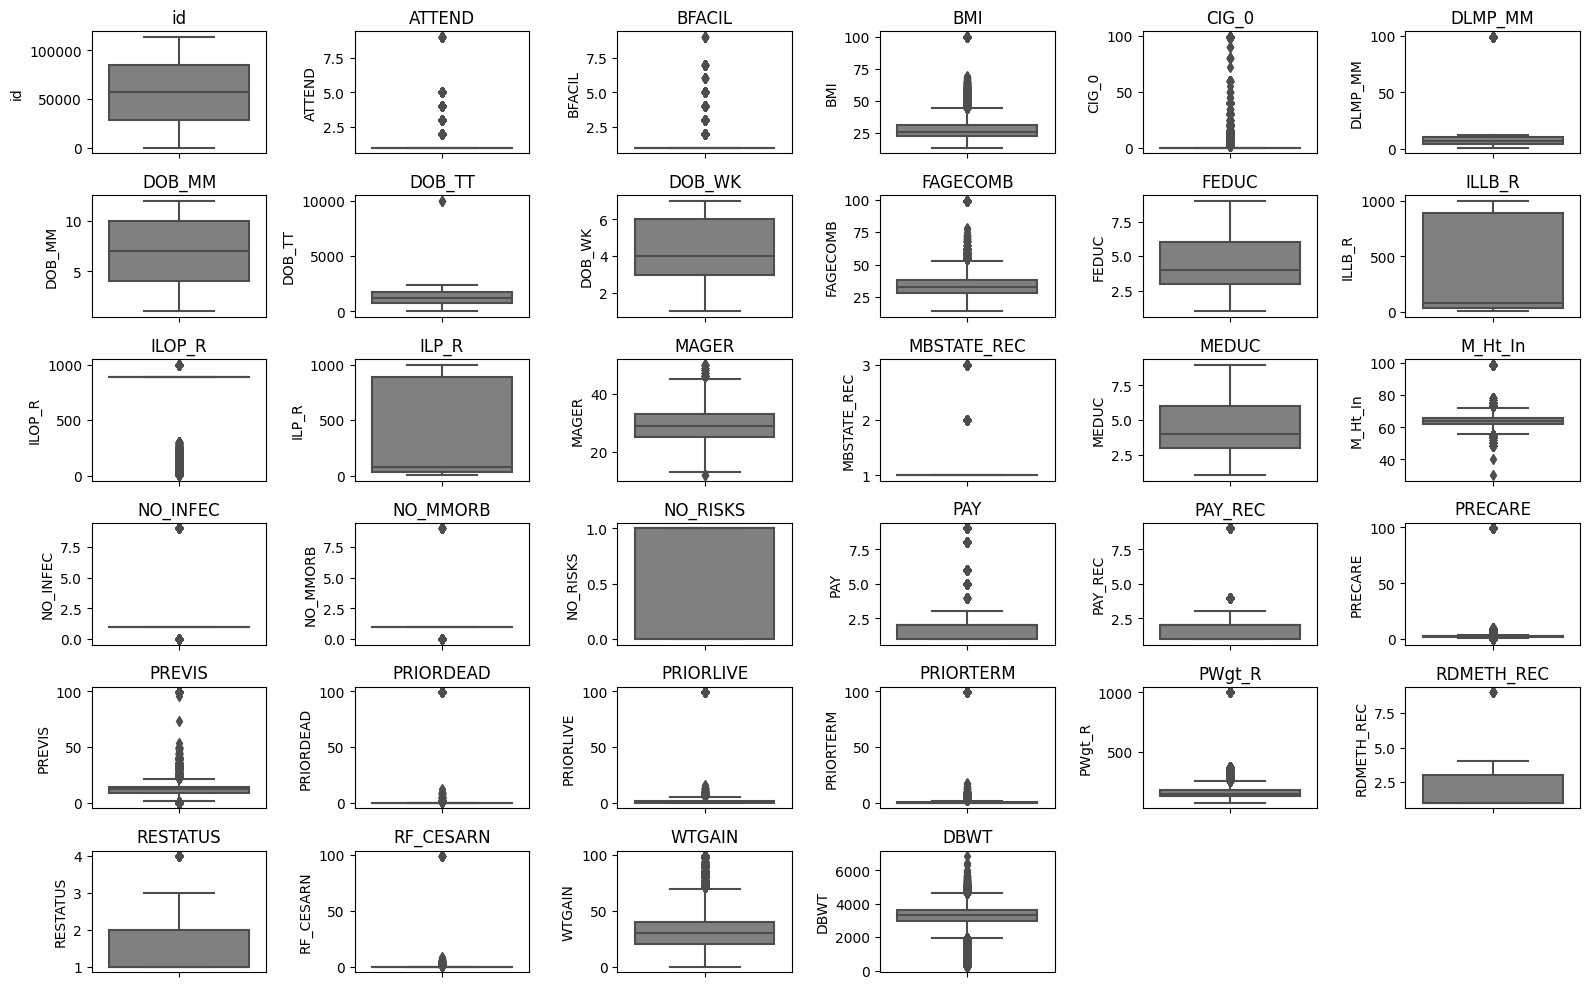

In [5]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(16, 10))

for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(6, 6, i)
    sns.boxplot(y=df[column], color='grey')
    plt.title(column)

plt.tight_layout()
plt.show();

In [6]:
print('-----------------------')
print('The data skewness:')
print('-----------------------')
df[numeric_columns].skew().sort_values(ascending=False)

-----------------------
The data skewness:
-----------------------


RF_CESARN      45.850353
NO_MMORB       24.980350
PRIORLIVE      21.359333
PRIORDEAD      20.765477
PRIORTERM      17.363645
NO_INFEC       16.610893
BFACIL         12.343074
CIG_0           9.169618
PRECARE         6.031646
PWgt_R          5.736726
PREVIS          5.272497
DLMP_MM         4.075119
BMI             4.012036
M_Ht_In         3.936267
PAY             3.485413
PAY_REC         3.371451
ATTEND          2.752336
FAGECOMB        2.038247
RESTATUS        1.423618
WTGAIN          1.395713
MBSTATE_REC     1.348409
RDMETH_REC      0.963211
FEDUC           0.446503
ILLB_R          0.361137
ILP_R           0.304352
MEDUC           0.290742
MAGER           0.077012
id              0.000000
DOB_WK         -0.022363
DOB_TT         -0.031466
DOB_MM         -0.036591
NO_RISKS       -0.800000
DBWT           -0.881886
ILOP_R         -1.678710
dtype: float64

Further, we better reduce skewness.

## Feature Engineering

- Eliminate skewness
- Scaling
- One-hot encoding for categorical

In [7]:
numeric_columns_to_normalize = [col for col in numeric_columns if col not in ['id', 'DBWT']]
numeric_data = df[numeric_columns_to_normalize]

# Box-Cox
normalized_data = pd.DataFrame()
for column in numeric_data.columns:
    normalized_column = None
    if column in numeric_columns_to_normalize:
        normalized_column, _ = boxcox(numeric_data[column] + 1)
    else:
        normalized_column = numeric_data[column]
    normalized_data[column] = normalized_column

# Scaling
scaler = MinMaxScaler()
normalized_data_scaled = scaler.fit_transform(normalized_data)
normalized_data_scaled = pd.DataFrame(normalized_data_scaled, columns=numeric_data.columns)
normalized_data_scaled[['id', 'DBWT']] = df[['id', 'DBWT']]
df[numeric_columns_to_normalize] = normalized_data_scaled[numeric_columns_to_normalize]
skewness_after = df[numeric_columns_to_normalize].skew()

In [8]:
print("Skewness after normalization:\n", df[numeric_columns].skew().sort_values(ascending=False))

Skewness after normalization:
 PRIORDEAD      8.310744
CIG_0          2.922192
RF_CESARN      1.877712
ATTEND         1.573957
MBSTATE_REC    1.286702
NO_MMORB       1.050728
PRIORTERM      1.022236
RESTATUS       0.861390
RDMETH_REC     0.697972
PAY            0.140765
WTGAIN         0.100316
PAY_REC        0.100054
PREVIS         0.086877
PRIORLIVE      0.080949
NO_INFEC       0.068824
FAGECOMB       0.036347
BMI            0.018204
ILLB_R         0.007226
BFACIL         0.000000
id             0.000000
ILP_R         -0.004618
PWgt_R        -0.016753
FEDUC         -0.026153
MAGER         -0.027282
MEDUC         -0.038345
DLMP_MM       -0.068975
DOB_WK        -0.126606
DOB_MM        -0.176493
DOB_TT        -0.273601
PRECARE       -0.471747
NO_RISKS      -0.800000
DBWT          -0.881886
M_Ht_In       -0.899855
ILOP_R        -1.604369
dtype: float64


In [9]:
categorical_columns = ['DMAR', 'LD_INDL', 'RF_CESAR', 'SEX']
one_hot_encoded = pd.get_dummies(df[categorical_columns], prefix=categorical_columns)
df = df.drop(columns=categorical_columns)
df = pd.concat([df, one_hot_encoded], axis=1)
print(df.head())

   id    ATTEND  BFACIL       BMI     CIG_0   DLMP_MM    DOB_MM    DOB_TT  \
0   0  0.000000     0.0  0.399194  0.000000  0.623400  0.840709  0.200973   
1   1  0.000000     0.0  0.388978  0.992821  0.349138  1.000000  0.281549   
2   2  0.000000     0.0  0.679944  0.000000  0.272819  1.000000  0.178327   
3   3  0.000000     0.0  0.603230  0.000000  0.493957  0.315330  0.225582   
4   4  0.963703     0.0  0.592163  0.000000  0.454888  0.216639  0.117814   

     DOB_WK  FAGECOMB     FEDUC    ILLB_R    ILOP_R     ILP_R     MAGER  \
0  0.692806  1.000000  1.000000  0.979185  0.828638  0.978408  0.614611   
1  0.848571  0.785168  0.741381  0.557295  1.000000  1.000000  0.787488   
2  0.188260  0.682020  0.518238  0.602646  1.000000  1.000000  0.787488   
3  0.188260  1.000000  1.000000  0.979185  0.828638  0.978408  0.352274   
4  0.188260  0.682020  0.380558  0.483919  0.828638  0.474594  0.486059   

   MBSTATE_REC     MEDUC   M_Ht_In  NO_INFEC  NO_MMORB  NO_RISKS       PAY  \
0     0.

## Splitting the dataset
- splitting the train set to validation

In [10]:
# splitting df dataset into train and validation

df_test = df[df_len:]
df_train = df[:df_len]

X = df_train.drop(labels = ["DBWT"], axis = 1)
y = df_train["DBWT"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

## Modeling

In [11]:
estimator = CatBoostRegressor(learning_rate=0.09886907332732021, 
                                    depth=10, 
                                    subsample=0.9045876332454507, 
                                    colsample_bylevel=0.5525983482670428, 
                                    min_data_in_leaf=10)

model = MapieRegressor(estimator=estimator,cv=10, method="plus")
model.fit(X_train, y_train)

preds, cov = model.predict(y_train, alpha=[0.1])
lower_interval = cov[:, 0]
upper_interval = cov[:, 1]

0:	learn: 582.0775419	total: 120ms	remaining: 2m
1:	learn: 575.4597143	total: 181ms	remaining: 1m 30s
2:	learn: 569.6708055	total: 243ms	remaining: 1m 20s
3:	learn: 564.4766781	total: 293ms	remaining: 1m 12s
4:	learn: 560.2052227	total: 349ms	remaining: 1m 9s
5:	learn: 556.3946153	total: 399ms	remaining: 1m 6s
6:	learn: 552.9006143	total: 450ms	remaining: 1m 3s
7:	learn: 550.0753252	total: 504ms	remaining: 1m 2s
8:	learn: 547.1876657	total: 559ms	remaining: 1m 1s
9:	learn: 544.8909815	total: 604ms	remaining: 59.8s
10:	learn: 542.4459601	total: 653ms	remaining: 58.7s
11:	learn: 540.0310919	total: 702ms	remaining: 57.8s
12:	learn: 538.0361295	total: 752ms	remaining: 57.1s
13:	learn: 536.0947604	total: 805ms	remaining: 56.7s
14:	learn: 534.4615012	total: 860ms	remaining: 56.5s
15:	learn: 533.1789046	total: 916ms	remaining: 56.3s
16:	learn: 531.4881994	total: 966ms	remaining: 55.9s
17:	learn: 530.1370830	total: 1.02s	remaining: 55.5s
18:	learn: 529.1076837	total: 1.07s	remaining: 55.3s
19:

MapieRegressor(cv=10,
               estimator=<catboost.core.CatBoostRegressor object at 0x7f583cbb8790>)

## Prediction on test data

In [12]:
preds, cov = model.predict(df_test, alpha=[0.1])
lower_interval = cov[:, 0]
upper_interval = cov[:, 1]

## Uploading results

In [13]:
submit = pd.DataFrame({'id':df_test['id'],
                      'pi_lower':np.ravel(lower_interval),
                      'pi_upper':np.ravel(upper_interval)})
submit.to_csv('submission.csv',index=False)

## How to improve the result

- Hyperparameter tuning;
- Apply different models: NNs, XGBoost - are the good candidates;
- Cross-featuring for enlarging the dataset;
- Go deeper for the expertise.